In [11]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)
!nvidia-smi

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.phy.mimo import StreamManagement

#from sionna.phy.ofdm import CSIGridMapper
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, ResourceGridDemapper, LSChannelEstimator, LMMSEEqualizer
from sionna.phy.ofdm import OFDMModulator, OFDMDemodulator, RemoveNulledSubcarriers, ZFEqualizer

from sionna.phy.channel.tr38901 import Antenna, AntennaArray, CDL, UMi, UMa, RMa
from sionna.phy.channel import gen_single_sector_topology as gen_topology
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel
from sionna.phy.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel

from sionna.phy.fec.ldpc.encoding import LDPC5GEncoder
from sionna.phy.fec.ldpc.decoding import LDPC5GDecoder

from sionna.phy.mapping import Mapper, Demapper, BinarySource, QAMSource

from sionna.phy.utils import ebnodb2no, sim_ber
from sionna.phy.utils.metrics import compute_ber
# from sionna.ofdm import CSIGridMapper

Number of GPUs available : 1
Only GPU number 0 used.
Mon Aug 25 00:52:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              8W /  125W |   10473MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N

## PHY Configurations

Tx_Power: 0.17728766960431616
Noise: -120.22878745280337


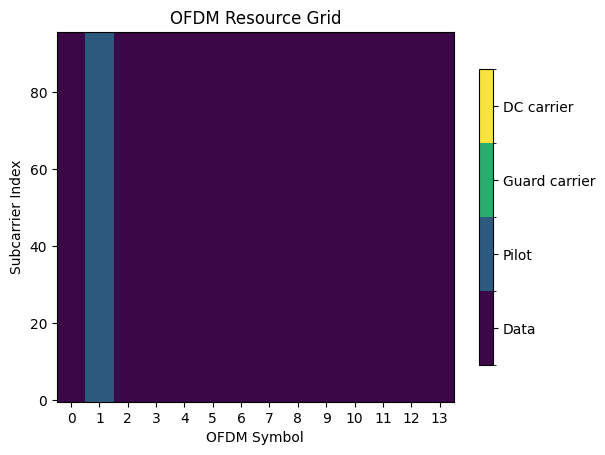

In [40]:
scenario = "umi"
carrier_frequency = 5.3e9
direction = "uplink"
num_ut = 1
batch_size = 20000

num_RB   = 8
num_symbols = 14
num_SC = 96
fft_size = 12*num_RB
subcarrier_spacing = 30e3

## Tx Power
TxPower_dBm     = 20 # in dBm
TxPower         = 10**((TxPower_dBm-30)/10)
TxPower_SC      = TxPower/(num_SC)
TxPower_SC_dBm  = 10*np.log10(TxPower_SC*1000)

# Noise Power
noise_psd       = -174                                  # in dBm/Hz
noise_figure    = 9                                     # in dB
noise_SC_Watt   = 10**((noise_psd + noise_figure - 30)/10)*subcarrier_spacing
noise_SC_dBm    = 10*np.log10(noise_SC_Watt*1000)

print("Tx_Power:",TxPower_SC_dBm)
print("Noise:",noise_SC_dBm)

tf.random.set_seed(1)
# Define the UT antenna array
ut_array = Antenna(polarization="single",
                   polarization_type="V",
                   antenna_pattern="omni",
                   carrier_frequency=carrier_frequency)

# Define the BS antenna array
bs_array = AntennaArray(num_rows=1,
                             num_cols=1, # We want to transmitter to be equiped with the 16 rx antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             polarization_type="V",
                             antenna_pattern="omni",
                             polarization="single",
                             carrier_frequency=5.3e9)

# Create channel model
channel_model = UMi(carrier_frequency=carrier_frequency,
                    o2i_model="low",
                    ut_array=ut_array,
                    bs_array=bs_array,
                    direction=direction,
                    enable_pathloss=True,
                    enable_shadow_fading=True)

# Generate the topology
ut_dist = 10
topology = gen_topology(batch_size, num_ut, scenario,min_bs_ut_dist=ut_dist, min_ut_velocity=0.33, max_ut_velocity=8.33,indoor_probability=0)

# Set the topology
channel_model.set_topology(*topology)
ut_loc = topology[0]
bs_loc = topology[1]
ut_vel = topology[4]

# The number of transmitted streams is equal to the number of UT antennas
num_streams_per_tx = 1

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.zeros([1, num_ut])
rx_tx_association[:, 0] = 1
#rx_tx_association[:, 1] = 1

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly simple. However, it can get complicated
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=fft_size,
                  subcarrier_spacing=subcarrier_spacing,
                  num_tx=num_ut,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=0,
                  pilot_pattern = "kronecker",
                  pilot_ofdm_symbol_indices = [1])
rg.show();

## Classical Communication Blocks

In [41]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.3 # The code rate
n = int(rg.num_data_symbols*num_bits_per_symbol)  # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()
qam_source = QAMSource(num_bits_per_symbol)

# The encoder maps information bits to coded bits
#encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# CSI-RS mapper
#csi_mapper = CSIGridMapper(rg)

rg_demap = ResourceGridDemapper(rg, sm)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)
# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# CSI-RS estimator will provide the raw channel estimates
#csi_est = CSIrsChannelEstimator(rg, sm)
#csi_est = CSIrsChannelEstimator(rg, sm, TxPower_SC, interpolation_type = 'lin')

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
zf_equ = ZFEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
#decoder = LDPC5GDecoder(encoder, hard_out=True)

# OFDM CHannel
ofdm_channel = OFDMChannel(channel_model, rg, add_awgn=True, normalize_channel=True, return_channel=True)
channel_freq = ApplyOFDMChannel(add_awgn=True)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)



## Executing Classical Communication System

In [42]:
tf.random.set_seed(42)

# --------- Transmitter ---------
b = binary_source([batch_size, num_ut, rg.num_streams_per_tx, n])  # n must equal (#data_REs * bits_per_sym)
# c = encoder(b)  # keep commented for uncoded link

x = mapper(b)
#x_map    = np.sqrt(TxPower_SC) * x                  # map bits -> constellation symbols
x_rg = rg_mapper(x)              # map to OFDM resource grid (data REs only)

# --------- Channel ---------
a, tau = channel_model(num_time_samples=rg.num_ofdm_symbols,
                       sampling_frequency=1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)

# --------- Receive ---------
no = no = sionna.phy.utils.ebnodb2no(ebno_db=3.0,
                        num_bits_per_symbol=num_bits_per_symbol,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
y  = channel_freq(x_rg, h_freq, no)
print("Received Signal Shape:", y.shape)  # e.g., (N,1,1,S,F)
print("Received Power : ", tf.reduce_mean(tf.abs(y)**2))

# Channel estimation 

h_freq_d_DL_hat, _ = ls_est (y, no)
print(y.shape)
print(h_freq_d_DL_hat.shape)
# ZF equalization
x_hat, no_eff = zf_equ(y, h_freq_d_DL_hat, tf.zeros_like(h_freq_d_DL_hat), no)

# Demap to bit LLRs for **data REs only**
llr = demapper(x_hat, no_eff)  # shape typically (N, 1, 1, E) or (N,1,1,S,F,B) depending on demapper

# --------- Uncoded hard decisions (NO LDPC decoder here) ---------
# Flatten both LLRs and labels, align lengths, and compute BER
llr_flat = tf.reshape(llr, [tf.shape(llr)[0], -1])              # (N, E)
b_hat    = tf.cast(llr_flat > 0.0, tf.float32)                  # (N, E)

b_flat   = tf.reshape(tf.cast(b, tf.float32), [tf.shape(b)[0], -1])  # (N, n)


# --------- Metrics ---------
mse = tf.reduce_mean(tf.abs(h_freq_d_DL_hat - h_freq)**2)
nmse = mse / (tf.reduce_mean(tf.abs(h_freq)**2) + 1e-12)
print("CSI Est NMSE :", nmse.numpy())

ber = compute_ber(b_flat, b_hat).numpy()
print("BER:", ber)


Received Signal Shape: (20000, 1, 1, 14, 96)
Received Power :  tf.Tensor(1.2507007, shape=(), dtype=float32)
Received Pilot Pattern Power :  tf.Tensor(1.250765, shape=(), dtype=float32)
Pilot Pattern Power :  tf.Tensor(0.9999998, shape=(), dtype=float32)
(20000, 1, 1, 14, 96)
(20000, 1, 1, 1, 1, 14, 96)
CSI Est NMSE : 0.2599951
BER: 0.10162267628205128


(20000, 14, 96, 2)


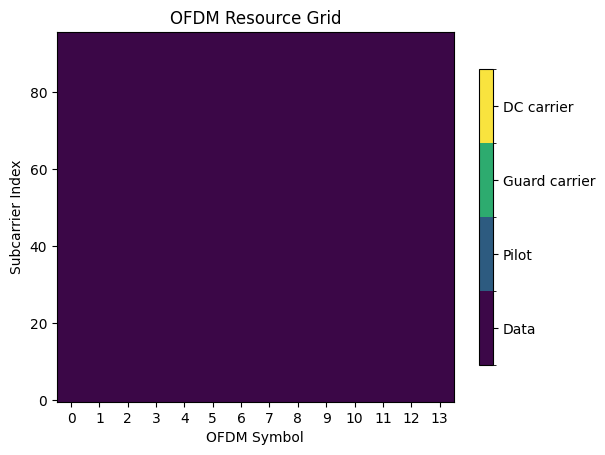

In [43]:
rg2 = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=fft_size,
                  subcarrier_spacing=subcarrier_spacing,
                  num_tx=num_ut,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=0,
                  pilot_pattern = None,
                  pilot_ofdm_symbol_indices = None)
rg2.show();

pilots = rg_mapper(x)

rg_demap = ResourceGridDemapper(rg2, sm)
orig_symbols = rg_demap(pilots)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol, hard_out=True)
orig_bits = demapper(orig_symbols, 0.0) 
# Reshape the last dimension to (14, 96)
orig_bits = tf.reshape(orig_bits, (batch_size, 14, 96, 2))
print(orig_bits.shape)


## Preprocessing Data for NeuralRx

In [44]:
# ----------------------------
# Prepare model inputs with SAME shapes you’ve been using
#   - input_y : (B,1,S,F) complex64
#   - input_h : (B,1,S,F) complex64
#   - input_p : (B,1,S,F) complex64
# ----------------------------
# y is already (B,1,1,S,F) -> squeeze stream axis to get (B,1,S,F)
tf.random.set_seed(42)

# ----------------------------
# Short-hands for dims
# ----------------------------
S = rg.num_ofdm_symbols  # 14
F = num_SC               # 96  (active SC count used by your RG)
B = batch_size

y_data = tf.squeeze(y, axis=2)

# h_freq is (B,1,1,1,1,S,F); remove antenna dims -> (B,S,F), then add channel dim -> (B,1,S,F)
h_tmp  = tf.squeeze(h_freq_d_DL_hat, axis=[1,2,3,4])                              # (B,S,F)
h_data = tf.expand_dims(h_tmp, axis=1)                                    # (B,1,S,F)

# ----------------------------
# Labels for training the NN receiver (same as before)
# ----------------------------
# If your loss expects flattened bits: (B,1,1,-1)
#llr_probs = tf.sigmoid(llr)
#llr_probs = tf.reshape(llr_probs, [B, 1, 1, -1])
#orig_bits =  tf.reshape(b_flat, [B, 1, 1, -1])

# Quick sanity checks
print("y_data  :", y_data.shape, y_data.dtype)   # (B,1,S,F) complex64
print("h_data  :", h_data.shape, h_data.dtype)   # (B,1,S,F) complex64
print("Ground Truth:", orig_bits.shape, orig_bits.dtype)


y_data  : (20000, 1, 14, 96) <dtype: 'complex64'>
h_data  : (20000, 1, 14, 96) <dtype: 'complex64'>
Ground Truth: (20000, 14, 96, 2) <dtype: 'float32'>


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# -------------------------
# ResNet block
# -------------------------
def resnet_block(x, filters, dilation, name):
    shortcut = x
    x = layers.SeparableConv2D(filters, (3,3), padding='same', dilation_rate=dilation,
                               activation='relu', name=f"{name}_sepconv1")(x)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.SeparableConv2D(filters, (3,3), padding='same', dilation_rate=dilation,
                               activation=None, name=f"{name}_sepconv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), padding='same', name=f"{name}_proj")(shortcut)
    x = layers.Add(name=f"{name}_add")([x, shortcut])
    x = layers.Activation('relu', name=f"{name}_relu")(x)
    return x

# -------------------------
# DeepRx model
# -------------------------
def build_deeprx(S=14, F=96, Nr=1, B=2):
    """
    S: OFDM symbols
    F: subcarriers
    Nr: RX antennas
    B: bits per symbol (output)
    """
    # Complex inputs split into real/imag
    inp_Y  = Input(shape=(S, F, Nr*2), name="Y_real_imag", dtype=tf.float32)      # Y: complex -> 2 channels
    #inp_Xp = Input(shape=(S, F, 1), name="Xp_real_imag", dtype=tf.float32)       # Xp: pilot (complex) -> 2 channels
    inp_Hr = Input(shape=(S, F, Nr*2), name="Hr_real_imag", dtype=tf.float32)    # Hr: complex -> 2 channels

    # Concatenate along last axis
    zc = layers.Concatenate(axis=-1)([inp_Y, inp_Hr])  # shape: (S, F, 2*Nc)

    # Conv in
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_in')(zc)

    # ResNet blocks
    x = resnet_block(x, 64, (1,1), 'resblock1')
    #x = resnet_block(x, 64, (1,1), 'resblock2')
    x = resnet_block(x, 128, (2,3), 'resblock3')
    #x = resnet_block(x, 128, (2,3), 'resblock4')
    #x = resnet_block(x, 256, (2,3), 'resblock5')
    x = resnet_block(x, 256, (3,6), 'resblock6')
    x = resnet_block(x, 256, (2,3), 'resblock7')
    #x = resnet_block(x, 128, (2,3), 'resblock8')
    #x = resnet_block(x, 128, (2,3), 'resblock9')
    x = resnet_block(x, 64, (1,1), 'resblock10')
    x = resnet_block(x, 64, (1,1), 'resblock11')

    # Conv out
    x = layers.Conv2D(B, (1,1), padding='same', activation=None, name='conv_out')(x)
    out = layers.Activation('linear', name='llr_output')(x)

    model = Model(inputs=[inp_Y, inp_Hr], outputs=out, name='DeepRx_real')
    return model

# -------------------------
# Example usage
# -------------------------
Nr = 1
F = 96
S = 14
B = 2  # bits per subcarrier (QPSK)

receiver_model = build_deeprx(S=S, F=F, Nr=Nr, B=B)
receiver_model.summary()


Model: "DeepRx_real"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Y_real_imag         │ (None, 14, 96, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hr_real_imag        │ (None, 14, 96, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 14, 96, 4) │          0 │ Y_real_imag[0][0… │
│ (Concatenate)       │                   │            │ Hr_real_imag[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_in (Conv2D)    │ (None, 14, 96,    │      2,368 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock1_sepconv1  │ (None, 14, 96,    │      4,736 │ conv_in[0][0]     │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock1_bn1       │ (None, 14, 96,    │        256 │ resblock1_sepcon… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock1_sepconv2  │ (None, 14, 96,    │      4,736 │ resblock1_bn1[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock1_bn2       │ (None, 14, 96,    │        256 │ resblock1_sepcon… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock1_add (Add) │ (None, 14, 96,    │          0 │ resblock1_bn2[0]… │
│                     │ 64)               │            │ conv_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock1_relu      │ (None, 14, 96,    │          0 │ resblock1_add[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock3_sepconv1  │ (None, 14, 96,    │      8,896 │ resblock1_relu[0… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock3_bn1       │ (None, 14, 96,    │        512 │ resblock3_sepcon… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock3_sepconv2  │ (None, 14, 96,    │     17,664 │ resblock3_bn1[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock3_bn2       │ (None, 14, 96,    │        512 │ resblock3_sepcon… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock3_proj      │ (None, 14, 96,    │      8,320 │ resblock1_relu[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock3_add (Add) │ (None, 14, 96,    │          0 │ resblock3_bn2[0]… │
│                     │ 128)              │            │ resblock3_proj[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resblock3_relu      │ (None, 14, 96,    │          0 │ resblock3_add[0]

 Total params: 374,402 (1.43 MB)

 Trainable params: 371,074 (1.42 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [46]:
import tensorflow as tf
import numpy as np
import math
from tensorflow.keras.layers import Layer, LayerNormalization, Dropout, Conv2D, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam

# =========================
# Dataset split
# =========================
def ensure_split(y_data, h_data, bits_probs, train_ratio=0.8):
    N = y_data.shape[0]
    idx = tf.random.shuffle(tf.range(N))
    train_size = int(train_ratio * N)
    train_idx, val_idx = idx[:train_size], idx[train_size:]

    y_train = tf.gather(y_data, train_idx)
    y_val   = tf.gather(y_data, val_idx)
    h_train = tf.gather(h_data, train_idx)
    h_val   = tf.gather(h_data, val_idx)
    bits_train = tf.gather(bits_probs, train_idx)
    bits_val   = tf.gather(bits_probs, val_idx)

    return y_train, y_val, h_train, h_val, bits_train, bits_val, train_idx, val_idx

# =========================
# Binary LLR loss
# =========================
def binary_sigmoid_cross_entropy(bit_labels, pred_llr):
    bit_labels = tf.cast(bit_labels, pred_llr.dtype)
    bit_prob = tf.sigmoid(pred_llr)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(bit_labels, bit_prob))

# =========================
# Split complex into real+imag (along last axis)
# =========================
# Remove the singleton second dimension (1) and split complex into real+imag
def preprocess_complex(x):
    # x: (B, 1, S, F)
    x = tf.squeeze(x, axis=1)  # -> (B, S, F)
    x = tf.expand_dims(x, axis=-1)  # -> (B, S, F, 1)
    x = tf.concat([tf.math.real(x), tf.math.imag(x)], axis=-1)  # -> (B, S, F, 2*Nr)
    return x

# ========================= # Custom LR schedule # ========================= 

# Learning-rate schedule
# =========================
class CustomLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Warmup -> constant -> linear (or quadratic) decay driven by optimizer iterations."""
    def __init__(self, min_learning_rate, max_learning_rate, iter_limits, quad_decay=False):
        super().__init__()
        self.quad_decay = quad_decay
        self.min_lr = tf.constant(min_learning_rate, tf.float32)
        self.max_lr = tf.constant(max_learning_rate, tf.float32)
        self.warmup_end = tf.constant(iter_limits[0], tf.float32)
        self.decay_start = tf.constant(iter_limits[1], tf.float32)
        self.last_iter = tf.constant(iter_limits[2], tf.float32)
        if self.quad_decay:
            self.dec_slope = self.max_lr / tf.square(self.last_iter - self.decay_start + 1e-12)
        else:
            self.dec_slope = (self.min_lr - self.max_lr) / (self.last_iter - self.decay_start + 1e-12)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        inc_slope = (self.max_lr - self.min_lr) / (self.warmup_end + 1e-12)
        def phase_warmup(): return self.min_lr + step * inc_slope
        def phase_const():  return self.max_lr
        def phase_decay():
            if self.quad_decay:
                return self.dec_slope * tf.square(step - self.last_iter)
            else:
                return self.max_lr + self.dec_slope * (step - self.decay_start)
        def phase_zero():   return tf.constant(0.0, tf.float32)
        return tf.case([
            (step < self.warmup_end, phase_warmup),
            (tf.logical_and(step >= self.warmup_end, step < self.decay_start), phase_const),
            (tf.logical_and(step >= self.decay_start, step < self.last_iter), phase_decay),
        ], default=phase_zero, exclusive=True)


# =========================
# Pilot mask
# =========================
#F = y_data.shape[3]  # number of subcarriers
#K = 4  # pilot spacing
#comb = tf.cast(tf.equal(tf.range(F) % K, 0), tf.float32)
# =========================
# Pilot mask
# =========================
T = y_data.shape[2]  # number of OFDM symbols
F = y_data.shape[3]  # number of subcarriers

# Keep only symbol 7, subcarrier 6
sc_mask = tf.zeros([1, 1, T, F], dtype=tf.float32)
sc_mask = tf.tensor_scatter_nd_update(sc_mask, [[0, 0, 7, 6]], [1.0])

# Apply mask to channel data (keep complex)
h_masked = h_data * tf.cast(sc_mask, tf.complex64)

# =========================
# Dataset split
# =========================
y_train, y_val, h_train, h_val, bits_train, bits_val, train_idx, val_idx = ensure_split(
    y_data, h_masked, orig_bits
)

print("Y_train shape:", y_train.shape, " dtype:", y_train.dtype)
print("H_train shape:", h_train.shape, " dtype:", h_train.dtype)

# =========================
# Normalize by average channel magnitude
# =========================
norm_factor = np.sqrt(np.mean(np.abs(h_train)**2))
y_train /= norm_factor
h_train /= norm_factor
y_val   /= norm_factor
h_val   /= norm_factor

# =========================
# Tile pilot mask to match OFDM symbols
# =========================
S = y_train.shape[2]  # number of OFDM symbols

# =========================
# Split complex into real+imag (along last axis)
y_train_proc = preprocess_complex(y_train)
y_val_proc   = preprocess_complex(y_val)
h_train_proc = preprocess_complex(h_train)
h_val_proc   = preprocess_complex(h_val)


print("Y_train_proc:", y_train_proc.shape, y_train_proc.dtype)
print("H_train_proc:", h_train_proc.shape, h_train_proc.dtype)


#llr_train = tf.tile(llr_train, [1, 1, S, 1])
#llr_val   = tf.tile(llr_val, [1, 1, S, 1])

# =========================
# Build & compile model
# =========================
Nr = 1
B  = bits_train.shape[-1]


batch_size = 32
total_epochs = 100
steps_per_epoch = math.ceil(y_train.shape[0]/batch_size)
iter_limits = [6*steps_per_epoch, 22*steps_per_epoch, total_epochs*steps_per_epoch]

lr_schedule = CustomLRSchedule(0.0, 1e-2, iter_limits)

receiver_model.compile(optimizer=Adam(lr_schedule),
                       loss=binary_sigmoid_cross_entropy)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, min_delta=1e-4)

# =========================
# Train
# =========================
history = receiver_model.fit(
    [y_train_proc, h_train_proc],
    bits_train,
    validation_data=([y_val_proc, h_val_proc], bits_val),
    batch_size=batch_size,
    epochs=total_epochs,
    callbacks=[early_stop],
    verbose=1
)


Y_train shape: (16000, 1, 14, 96)  dtype: <dtype: 'complex64'>
H_train shape: (16000, 1, 14, 96)  dtype: <dtype: 'complex64'>
Y_train_proc: (16000, 14, 96, 2) <dtype: 'float32'>
H_train_proc: (16000, 14, 96, 2) <dtype: 'float32'>
Xp_train_proc: (16000, 196, 96, 1) <dtype: 'float32'>
Epoch 1/100


2025-08-25 01:18:01.808960: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator adam/case/Assert/AssertGuard/Assert


500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - loss: 0.9563 - val_loss: 0.6894
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.4977 - val_loss: 0.1875
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.1675 - val_loss: 0.1613
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.1466 - val_loss: 0.1641
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.1328 - val_loss: 0.1615
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.1240 - val_loss: 0.1426
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.1196 - val_loss: 0.1202
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.1155 - val_loss: 0.1167
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.1127 - val_loss: 0.1146
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.1118 - val_loss: 0.1137
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.1102 - val_loss: 0.1204
Epoch 12/100
500/500 ━━━━━━━━━━

KeyboardInterrupt: 

In [47]:
# ==== Evaluate after training (validation split) ====

# 1) Predict LLRs with the neural receiver  (NOTE: 2 inputs!)
llr_pred = receiver_model.predict([y_val_proc, h_val_proc], batch_size=32, verbose=0)  # (valN, 1, 1, B_data)
bit_prob = llr_pred > 0

print(bit_prob.shape)
print(bits_val.shape)

ber_neural = compute_ber(bit_prob, bits_val)
print("BER Neural :", ber_neural)


(4000, 14, 96, 2)
(4000, 14, 96, 2)
BER Neural : tf.Tensor(0.04974516369047619, shape=(), dtype=float64)


In [48]:
y_classical = tf.expand_dims(y_val, axis=2)
print(h_data.shape)
h_val   = tf.gather(h_data, val_idx)
b_val   = tf.gather(b, val_idx)
h_val = tf.reshape(h_val, [4000, 1, 1, 1, 1, 14, 96])

# ZF equalization
print(y_val.shape)
print(h_val.shape)
x_hat, no_eff = zf_equ(y_classical, h_val, tf.zeros_like(h_val), no)

# Demap to bit LLRs for **data REs only**
llr = demapper(x_hat, no_eff)  # shape typically (N, 1, 1, E) or (N,1,1,S,F,B) depending on demapper

# --------- Uncoded hard decisions (NO LDPC decoder here) ---------
# Flatten both LLRs and labels, align lengths, and compute BER
llr_flat = tf.reshape(llr, [tf.shape(llr)[0], -1])              # (N, E)
b_hat    = tf.cast(llr_flat > 0.0, tf.float32)                  # (N, E)
b_val_flat   = tf.reshape(tf.cast(b_val, tf.float32), [tf.shape(b_val)[0], -1])  # (N, n)

# --------- Metrics ---------
mse = tf.reduce_mean(tf.abs(h_freq_d_DL_hat - h_freq)**2)
nmse = mse / (tf.reduce_mean(tf.abs(h_freq)**2) + 1e-12)
print("CSI Est NMSE :", nmse.numpy())

print(b_val_flat.shape)
print(b_hat.shape)

ber = compute_ber(b_val_flat, b_hat).numpy()
print("BER:", ber)


(20000, 1, 14, 96)
(4000, 1, 14, 96)
(4000, 1, 1, 1, 1, 14, 96)
CSI Est NMSE : 0.2599951
(4000, 2496)
(4000, 2496)
BER: 0.10131690705128205


## Visualizing BER vs Ebno for both Receivers

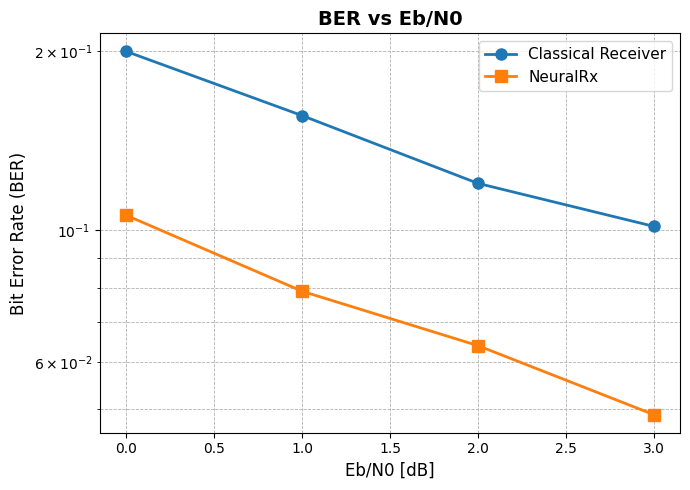

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Eb/N0 range (dB)
ebno_db = np.arange(0, 4, 1)

# Hypothetical BER values for classical and neural receivers
# (Here we just simulate two curves for demonstration purposes)
ber_classical = np.array([0.2, 0.156, 0.12, 0.1016])  # classical
ber_neural    = np.array([0.106, 0.079, 0.064, 0.049])  # neural (better)

# Plot
plt.figure(figsize=(7,5))
plt.semilogy(ebno_db, ber_classical, 'o-', label="Classical Receiver", linewidth=2, markersize=8)
plt.semilogy(ebno_db, ber_neural, 's-', label="NeuralRx", linewidth=2, markersize=8)

plt.grid(True, which="both", ls="--", linewidth=0.6)
plt.xlabel("Eb/N0 [dB]", fontsize=12)
plt.ylabel("Bit Error Rate (BER)", fontsize=12)
plt.title("BER vs Eb/N0", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()
